In [1]:
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

## VaderSentiment

https://github.com/cjhutto/vaderSentiment

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [31]:
def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text).pop('compound', None)
    if vs > 0.05:
        return 'POS'
    
    elif vs < -0.05:
        return 'NEG'
    
    return 'NEU'

In [32]:
for s in sentences:
    print(get_vader_sentiment(s),":", s)

POS : VADER is smart, handsome, and funny.
POS : VADER is smart, handsome, and funny!
POS : VADER is very smart, handsome, and funny.
POS : VADER is VERY SMART, handsome, and FUNNY.
POS : VADER is VERY SMART, handsome, and FUNNY!!!
POS : VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
NEG : VADER is not smart, handsome, nor funny.
POS : The book was good.
POS : At least it isn't a horrible book.
POS : The book was only kind of good.
NEG : The plot was good, but the characters are uncompelling and the dialog is not great.
NEG : Today SUX!
POS : Today only kinda sux! But I'll get by, lol
POS : Make sure you :) or :D today!
POS : Catch utf-8 emoji such as such as 💘 and 💋 and 😁
POS : Not bad at all


## Transformers

https://github.com/cardiffnlp/tweeteval

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

MODELPATH = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODELPATH)
model = AutoModelForSequenceClassification.from_pretrained(MODELPATH)
model.save_pretrained(MODELPATH)
tokenizer.save_pretrained(MODELPATH)

('cardiffnlp/twitter-roberta-base-sentiment/tokenizer_config.json',
 'cardiffnlp/twitter-roberta-base-sentiment/special_tokens_map.json',
 'cardiffnlp/twitter-roberta-base-sentiment/vocab.json',
 'cardiffnlp/twitter-roberta-base-sentiment/merges.txt',
 'cardiffnlp/twitter-roberta-base-sentiment/added_tokens.json',
 'cardiffnlp/twitter-roberta-base-sentiment/tokenizer.json')

In [6]:
#https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt
mapping = {0: 'NEG', 1: 'NEU', 2:'POS'}

In [7]:
def get_transformers_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1][0]
    result = mapping[ranking]
    
    return result

In [8]:
for s in sentences:
    print(get_transformers_sentiment(s),":", s)

POS : VADER is smart, handsome, and funny.
POS : VADER is smart, handsome, and funny!
POS : VADER is very smart, handsome, and funny.
POS : VADER is VERY SMART, handsome, and FUNNY.
POS : VADER is VERY SMART, handsome, and FUNNY!!!
POS : VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
NEG : VADER is not smart, handsome, nor funny.
POS : The book was good.
NEU : At least it isn't a horrible book.
POS : The book was only kind of good.
NEG : The plot was good, but the characters are uncompelling and the dialog is not great.
NEU : Today SUX!
NEU : Today only kinda sux! But I'll get by, lol
POS : Make sure you :) or :D today!
NEU : Catch utf-8 emoji such as such as 💘 and 💋 and 😁
POS : Not bad at all


## Comparison

In [33]:
for s in sentences:
    v = get_vader_sentiment(s)
    t = get_transformers_sentiment(s)
    print("Matching? ", v == t, "      Sentence: ", s)
    print("Vader: ", v, "     ", "Transformers: ", t, "\n")

Matching?  True       Sentence:  VADER is smart, handsome, and funny.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is smart, handsome, and funny!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is very smart, handsome, and funny.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, handsome, and FUNNY.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, handsome, and FUNNY!!!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is not smart, handsome, nor funny.
Vader:  NEG       Transformers:  NEG 

Matching?  True       Sentence:  The book was good.
Vader:  POS       Transformers:  POS 

Matching?  False       Sentence:  At least it isn't a horrible book.
Vader:  POS       Transformers:  NEU

### Our case

In [11]:
import pandas as pd
import re
from tqdm import tqdm

In [15]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [12]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if t.startswith('$') else t
        
        new_text.append(t)
    return " ".join(new_text)

In [55]:
t = pd.read_csv("data/tweets.csv")
t["clean"] = [preprocess(i) for i in t.text]

In [56]:
t["vader"] = [get_vader_sentiment(s) for s in t.clean]

In [57]:
t["vader_int"] = t.vader.replace({'POS':1,'NEU':0,'NEG':-1})

In [58]:
t

,text,time,clean,vader,vader_int
0,$XRP.X,2022-01-07 16:07:00,,NEU,0
1,$XRP.X https://www.sec.gov/news/press-release/...,2022-01-07 16:07:00,why are they always in trouble ? Wtf🤷🏾‍♂️😂,NEG,-1
2,$XRP.X This is a golden opportunity for us mul...,2022-01-07 16:08:00,This is a golden opportunity for us multiyear...,POS,1
3,$XRP.X $ETH.X $BTC.X $ACH.X $HBAR.X ”LETS GO C...,2022-01-07 16:16:00,”LETS GO CHINA”!,NEU,0
4,$XRP.X $BTC.X $SPY I was looking for Biden’s l...,2022-01-07 16:19:00,I was looking for Biden’s live speech he’s ...,NEG,-1
...,...,...,...,...,...
23191,$XRP.X why are we still at the same price as w...,2022-02-10 15:46:00,why are we still at the same price as when BT...,NEG,-1
23192,BEARISH DIV 1HR $BTC.X $XRP.X,2022-02-10 15:50:00,BEARISH DIV 1HR,NEU,0
23193,$XRP.X Retail supply shock incoming Ripple is...,2022-02-10 15:50:00,Retail supply shock incoming Ripple is buyi...,NEG,-1
23194,$XRP.X how is this not at. 88 at least? Bitcoi...,2022-02-10 15:55:00,how is this not at. 88 at least? Bitcoin is a...,NEU,0


In [67]:
tosum = t[['time', 'vader_int']]
tosum["time"] = pd.to_datetime(tosum.time, utc = True) 
tosum["min"] = tosum.time.dt.floor("min")
tosum.min = tosum["min"].dt.tz_localize(None)
tosum["hour"] = tosum.time.dt.floor("H")
tosum.hour = tosum["hour"].dt.tz_localize(None)
tosum["day"] = tosum.time.dt.floor("D")
tosum.day = tosum["day"].dt.tz_localize(None)
tosum["pos"] = [1 if i == 1 else 0 for i in tosum.vader_int ]
tosum["neu"] = [1 if i == 0 else 0 for i in tosum.vader_int ]
tosum["neg"] = [1 if i == -1 else 0 for i in tosum.vader_int ]

/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_30905/3523033075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tosum["time"] = pd.to_datetime(tosum.time, utc = True)
/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_30905/3523033075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tosum["min"] = tosum.time.dt.floor("min")
/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_30905/3523033075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [68]:
tosum

,time,vader_int,min,hour,day,pos,neu,neg
0,2022-01-07 16:07:00+00:00,0,2022-01-07 16:07:00+00:00,2022-01-07 16:00:00,2022-01-07,0,1,0
1,2022-01-07 16:07:00+00:00,-1,2022-01-07 16:07:00+00:00,2022-01-07 16:00:00,2022-01-07,0,0,1
2,2022-01-07 16:08:00+00:00,1,2022-01-07 16:08:00+00:00,2022-01-07 16:00:00,2022-01-07,1,0,0
3,2022-01-07 16:16:00+00:00,0,2022-01-07 16:16:00+00:00,2022-01-07 16:00:00,2022-01-07,0,1,0
4,2022-01-07 16:19:00+00:00,-1,2022-01-07 16:19:00+00:00,2022-01-07 16:00:00,2022-01-07,0,0,1
...,...,...,...,...,...,...,...,...
23191,2022-02-10 15:46:00+00:00,-1,2022-02-10 15:46:00+00:00,2022-02-10 15:00:00,2022-02-10,0,0,1
23192,2022-02-10 15:50:00+00:00,0,2022-02-10 15:50:00+00:00,2022-02-10 15:00:00,2022-02-10,0,1,0
23193,2022-02-10 15:50:00+00:00,-1,2022-02-10 15:50:00+00:00,2022-02-10 15:00:00,2022-02-10,0,0,1
23194,2022-02-10 15:55:00+00:00,0,2022-02-10 15:55:00+00:00,2022-02-10 15:00:00,2022-02-10,0,1,0


,vader_int,pos,neu,neg,total
min,,,,,
2022-01-07 00:01:00+00:00,2,2,0,0,2
2022-01-07 00:07:00+00:00,2,2,0,0,2
2022-01-07 00:18:00+00:00,-1,0,0,1,1
2022-01-07 00:34:00+00:00,-2,0,0,2,2
2022-01-07 00:38:00+00:00,0,0,2,0,2


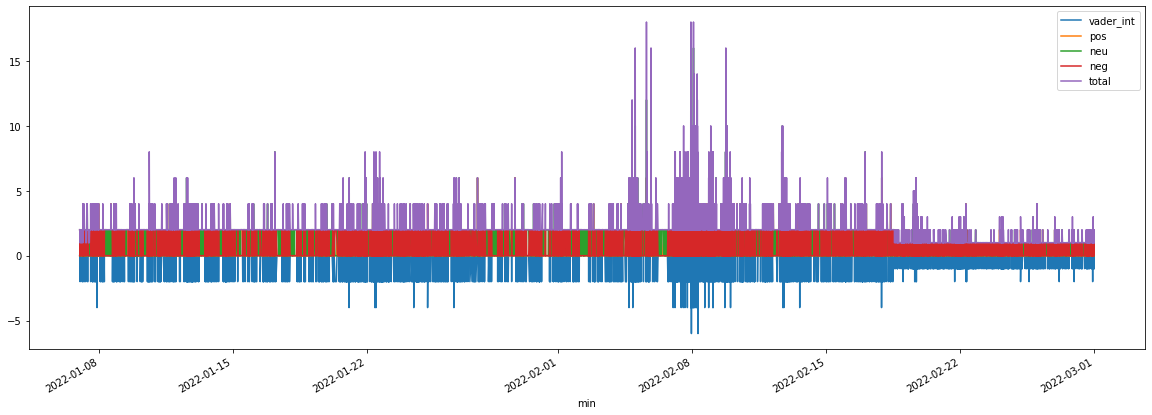

In [82]:
minutesum = tosum.groupby('min').sum()
minutesum["total"] = minutesum.pos + minutesum.neu + minutesum.neg
minutesum.plot(figsize = (20, 7))
minutesum.head()

,vader_int,pos,neu,neg,total
hour,,,,,
2022-01-07 00:00:00,0,4,3,4,11
2022-01-07 01:00:00,0,2,2,2,6
2022-01-07 02:00:00,3,3,4,0,7
2022-01-07 03:00:00,1,5,12,4,21
2022-01-07 04:00:00,8,12,12,4,28


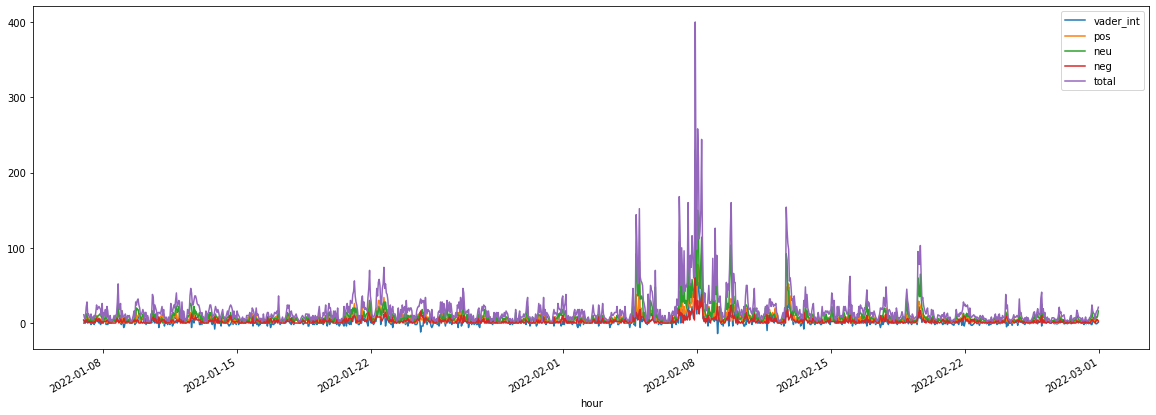

In [83]:
hoursum = tosum.groupby('hour').sum()
hoursum["total"] = hoursum.pos + hoursum.neu + hoursum.neg
hoursum.plot(figsize = (20, 7))
hoursum.head()

,vader_int,pos,neu,neg,total
day,,,,,
2022-01-07,63,117,157,54,328
2022-01-08,76,116,158,40,314
2022-01-09,80,122,140,42,304
2022-01-10,62,124,138,62,324
2022-01-11,80,132,190,52,374


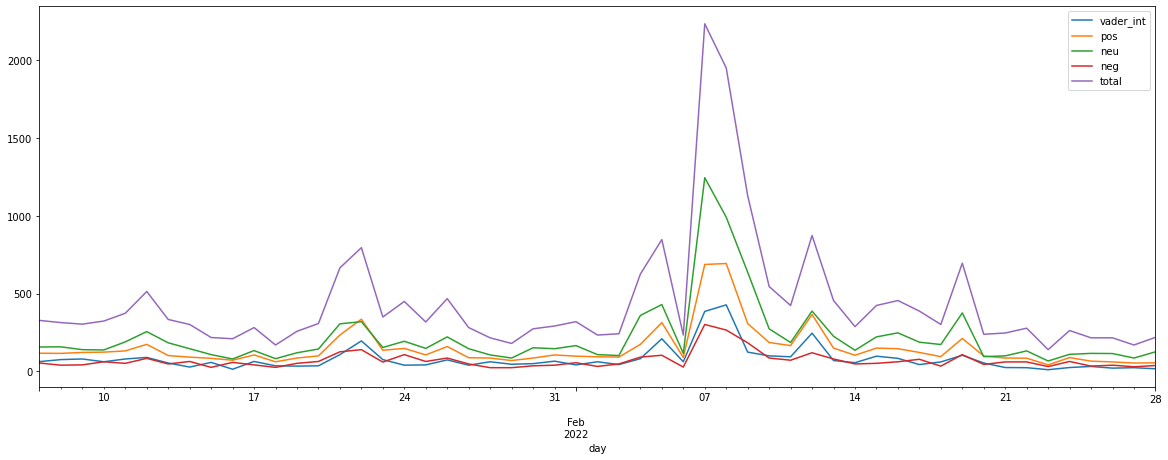

In [84]:
daysum = tosum.groupby('day').sum()
daysum["total"] = daysum.pos + daysum.neu + daysum.neg
daysum.plot(figsize = (20, 7))
daysum.head()